### CODE DESCRIPTION

The present notebook contains the running code of the Data Science in Action project challenge proposed by Deloitte in collaboration with Luiss University.
If you have not read the report it is suggested to read it before looking at the code.

- By running start to finish the outputs are the 6 csv files:

"Cross_Selling_DEM.csv"
"Cross_Selling_SMS.csv"
"Cross_Selling_TLS.csv"
"Solution_DEM.csv"
"Solution_SMS.csv"
"Solution_TLS.csv"

The libraries needed to run the script

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import random
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
dataset = pd.read_csv("DATASET.csv", sep=";",encoding='unicode_escape')
dataset.head()

,ID,GENRE,CONSENSUS_PRIVACY,LOYALTY_PROGRAM,LAST_MONTH_DESK_VISITS,LAST_3MONTHS_DESK_VISITS,LAST_YEAR_DESK_VISITS,LAST_MONTH_CC_REQUESTS,LAST_3MONTHS_CC_REQUESTS,LAST_YEAR_CC_REQUESTS,...,N_DEM_SOLUTION,N_SMS_SOLUTION,N_TLS_SOLUTION,YEAR_BIRTH,BEHAVIOUR_SCORE,CLC_STATUS,ACQUISITION_CHANNEL,LAST_GAS_PRODUCT,LAST_POWER_PRODUCT,LAST_CAMPAIGN_TIPOLOGY
0,10,M,YES,1,0,0,0,0,0,10,...,0,0,0,1959,GOOD PAYER,4-Risk churn,CC,Traditional,NaN,Cross-Selling
1,20,F,NO,1,0,0,0,0,0,0,...,0,0,0,1962,GOOD PAYER,3-Customer Loyalty,CC,Traditional,NaN,Communication
2,22,F,YES,0,0,0,0,0,0,0,...,0,0,0,1960,LATECOMER,2-Customer,CC,Traditional,NaN,Cross-Selling
3,26,M,YES,1,0,0,0,0,0,0,...,0,0,0,1924,GOOD PAYER,2-Customer,CC,Traditional,NaN,Cross-Selling
4,32,F,YES,0,0,0,0,0,0,1,...,0,0,0,1967,GOOD PAYER,2-Customer,CC,Traditional,NaN,Cross-Selling


A copy of the original dataset is created in order to have an initial untouched dataset.

In [4]:
dataset_start = dataset.copy() #copy of the original dataset

Since the variable "commodity" has more than two categories, the dummy variables are created and merged to the dataset_for_eda, that will be used for the exploratory data analyisis

In [5]:
dummies_for_eda = pd.get_dummies(dataset_start["COMMODITY"])
dataset_eda = pd.concat([dataset_start.reset_index(drop=True), dummies_for_eda.reset_index(drop=True)], axis=1) #the two datasets are merged

### EXPLORATORY DATA ANALYSIS
performed over the dataset: "dataset_eda"

### EDA on Commodity dual
In relation with the commodity_dual variable, which has 1/0 values depending on whether the customer has a dual contract or not.

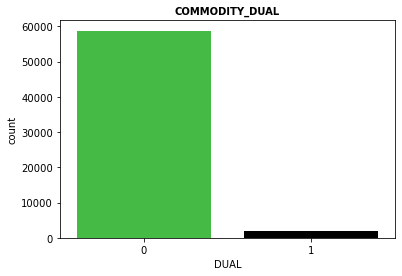

In [6]:
sns.countplot("DUAL", data=dataset_eda, palette=['limegreen',"black"])
plt.title('COMMODITY_DUAL', fontweight="bold", fontsize=10)
plt.show()

The two classes are quite unbalanced

DUAL/SOLUTION

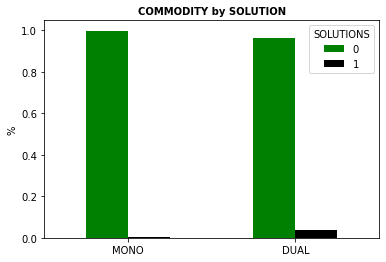

In [7]:
crosstab_commodity_solutions = pd.crosstab(index=dataset_eda["DUAL"],
                                           columns=dataset_eda["SOLUTIONS"], normalize='index') #creates dataset with index and column.
crosstab_commodity_solutions.plot.bar(figsize=(6, 4),
                                      rot=0,color=('green', 'black')).set(ylabel="%", xlabel="")

plt.title('COMMODITY by SOLUTION', fontweight="bold", fontsize=10)
plt.xticks([0, 1], ['MONO', 'DUAL'])
plt.show()

The customers with the "solution" contract are mainly those who have also subscribed a dual contract.

DUAL/WEB REGISTRATION

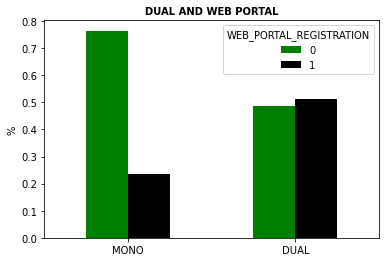

In [8]:
crosstab_loyalty_dual = pd.crosstab(index=dataset_eda["DUAL"],
                                    columns=dataset_eda["WEB_PORTAL_REGISTRATION"],
                                    normalize="index")

crosstab_loyalty_dual.plot.bar(figsize=(6, 4),
                               rot=0, color=('green', 'black')).set(ylabel="%", xlabel="")

plt.title('DUAL AND WEB PORTAL', fontweight="bold", fontsize=10)
plt.xticks([0, 1], ['MONO', 'DUAL'])
plt.show()

70% of the customers with a "dual" type of contract are also registered to the web portal.

25% of customers with a "mono" type of contract are registered to the web portal.

DUAL/PRIVACY

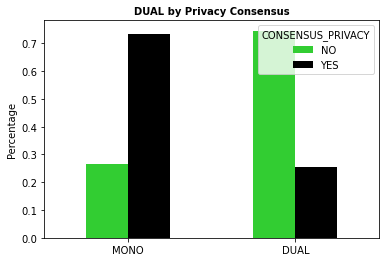

In [9]:
crosstab_privacy_solutions = pd.crosstab(index=dataset_eda["DUAL"],
                                         columns=dataset_eda["CONSENSUS_PRIVACY"], normalize='index')

crosstab_privacy_solutions.plot.bar(figsize=(6, 4),
                                    rot=0, color=('limegreen', 'black')).set(ylabel="Percentage", xlabel="")
plt.title('DUAL by Privacy Consensus', fontweight="bold", fontsize=10)
plt.xticks([0, 1], ['MONO', 'DUAL'])
plt.show()

DUAL/EMAIL_VALIDATED

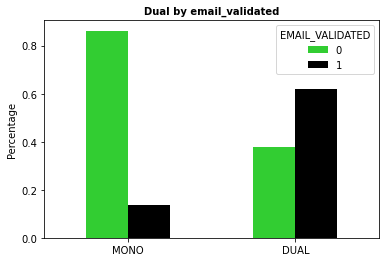

In [10]:
crosstab_dual_mail = pd.crosstab(index=dataset_eda["DUAL"],
                                 columns=dataset_eda["EMAIL_VALIDATED"], normalize='index')
crosstab_dual_mail.plot.bar(figsize=(6, 4),
                            rot=0, color=('limegreen', 'black')).set(ylabel="Percentage", xlabel="")

plt.title('Dual by email_validated', fontweight="bold", fontsize=10)
plt.xticks([0, 1], ['MONO', 'DUAL'])
plt.show()

60% of customers with a "dual" type of contract have their mail validated.

15% of customers with a "mono" type of contract have their mail validated.

### EDA over SOLUTIONS

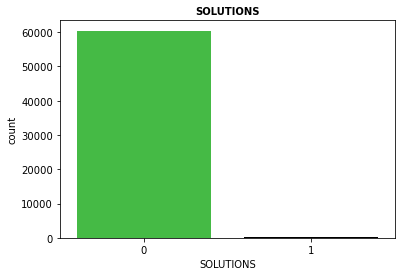

In [11]:
sns.countplot("SOLUTIONS", data=dataset, palette=('limegreen', 'black'))
plt.title('SOLUTIONS', fontweight="bold", fontsize=10)
plt.show()

The two classes are more unbalanced than the DUAL classes. There are only 176 customers with a "solution" contract.

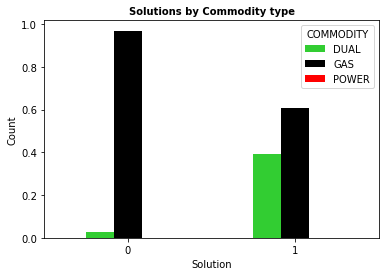

In [12]:

crosstab_commodity_solutions = pd.crosstab(index=dataset["SOLUTIONS"],
                                           columns=dataset["COMMODITY"], normalize='index')

crosstab_commodity_solutions.plot.bar(figsize=(6, 4),
                                      rot=0,color=('limegreen', 'black', "red")).set(ylabel="Count", xlabel="Solution")
plt.title('Solutions by Commodity type', fontweight="bold", fontsize=10)
plt.show()

Customers with the contract "Solution" are mainly customers with a "DUAL" or "GAS" type of contract.

SOLUTION/PRIVACY

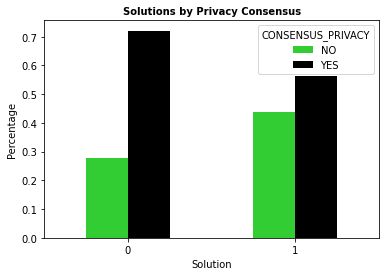

In [13]:
crosstab_privacy_solutions = pd.crosstab(index=dataset["SOLUTIONS"],
                                         columns=dataset["CONSENSUS_PRIVACY"], normalize='index')

crosstab_privacy_solutions.plot.bar(figsize=(6, 4),
                                    rot=0, color=('limegreen', 'black')).set(ylabel="Percentage", xlabel="Solution")
plt.title('Solutions by Privacy Consensus', fontweight="bold", fontsize=10)
plt.show()

SOLUTION/LOYALTY_PROGRAM

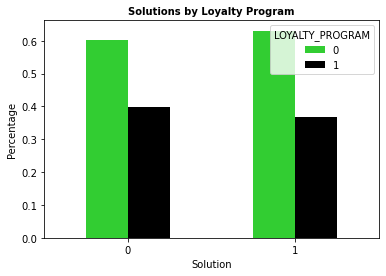

In [14]:
crosstab_loyaltyprog_solutions = pd.crosstab(index=dataset["SOLUTIONS"],
                                              columns=dataset["LOYALTY_PROGRAM"], normalize='index')
#plot
crosstab_loyaltyprog_solutions.plot.bar(figsize=(6, 4),
                                         rot=0, color=('limegreen', 'black')).set(ylabel="Percentage",
                                                                                       xlabel="Solution")
plt.title('Solutions by Loyalty Program', fontweight="bold", fontsize=10)
plt.show()

No great difference between the two type of customers under the Loyalty program variable.

SOLUTION/EMAIL_VALIDATED

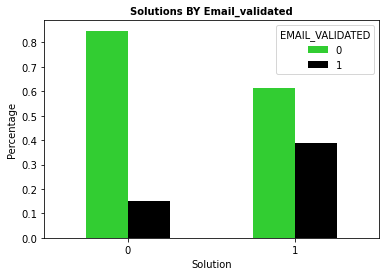

In [15]:
crosstab_genre_solutions = pd.crosstab(index=dataset_eda["SOLUTIONS"],
                                    columns=dataset["EMAIL_VALIDATED"], normalize='index')
crosstab_genre_solutions.plot.bar(figsize=(6, 4),
                               rot=0, color=('limegreen', 'black')).set(ylabel="Percentage", xlabel = "Solution")
plt.title('Solutions BY Email_validated', fontweight="bold", fontsize =10)
plt.show()

40% of the customer with the SOLUTION contract have the email validated.

15% of the ones without the SOLUTION contract have the email validated.

SOLUTION/WEB_PORTAL_REGISTRATION

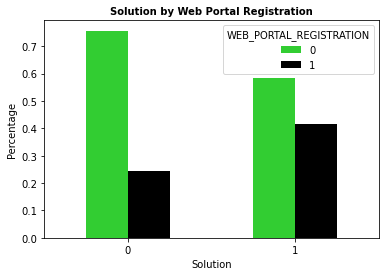

In [16]:
crosstab_flag_solutions = pd.crosstab(index=dataset["SOLUTIONS"],
                                    columns=dataset["WEB_PORTAL_REGISTRATION"], normalize='index')
crosstab_flag_solutions.plot.bar(figsize=(6, 4),
                               rot=0, color=('limegreen', 'black')).set(ylabel="Percentage", xlabel = "Solution")
plt.title('Solution by Web Portal Registration', fontweight="bold", fontsize =10)
plt.show()

40% of the customers with the solution contract are signed to the web portal.
25% of those without the solution contract are.

### DATA CLEANING

dataset: dataset_clean


Deleting customers at risk of being churned or leaving (they cannot be contacted for commercial purposes) and creating a new dataset: dataset_clean.

In [17]:
dataset_clean = dataset_start.drop(dataset_start[(dataset_start["CLC_STATUS"] == "4-Risk churn") & (dataset_start["CLC_STATUS"] == "5-Leaving")].index)

Filter the dataset for the numerical variables

In [18]:
outliers_detection_dataset = dataset_clean.filter(['LAST_MONTH_DESK_VISITS', 'LAST_3MONTHS_DESK_VISITS','LAST_YEAR_DESK_VISITS', 'LAST_MONTH_CC_REQUESTS',                                                              'LAST_3MONTHS_CC_REQUESTS', 'LAST_YEAR_CC_REQUESTS', 'N_GAS_POINTS', 'N_POWER_POINTS','N_DISUSED_GAS_POINTS',                                                        'N_DISUSED_POWER_POINTS', 'N_TERMINATED_GAS_PER_SWITCH','N_TERMINATED_POWER_PER_SWITCH',                                                                             'N_TERMINATED_GAS_PER_VOLTURA','N_TERMINATED_POWER_PER_VOLTURA', 'INBOUND_CONTACTS_LAST_MONTH',                                                                      'INBOUND_CONTACTS_LAST_2MONTHS', 'INBOUND_CONTACTS_LAST_YEAR', 'N_RISK_CASES_CHURN_GAS','N_RISK_CASES_CHURN_POWER',                                                  'N_MISSED_PAYMENTS', 'N_SWITCH_ANTI_CHURN', 'N_CAMPAIGN_SENT', 'N_CAMPAIGN_CLICKED','N_CAMPAIGN_OPENED',                                                             'N_DEM_CARING', 'N_SMS_CARING', 'N_TLS_CARING', 'N_DEM_RENEWAL','N_SMS_RENEWAL', 'N_TLS_RENEWAL',                                                                    'N_DEM_CROSS_SELLING','N_SMS_CROSS_SELLING', 'N_TLS_CROSS_SELLING', 'N_DEM_SOLUTION','N_SMS_SOLUTION',                                                               'N_TLS_SOLUTION', 'AVG_CONSUMPTION_GAS_M3','AVG_CONSUMPTION_POWER_KWH'], axis=1)

Replace the outliers with the respective median

In [19]:
for column in outliers_detection_dataset.columns:
    Q1 = outliers_detection_dataset[column].quantile(0.05)
    Q3 = outliers_detection_dataset[column].quantile(0.95)
    Q2 = outliers_detection_dataset[column].quantile(0.5)
    IQR = Q3 - Q1
    outliers_detection_dataset[column] = np.where(outliers_detection_dataset[column] < Q1, Q2, outliers_detection_dataset[column])
    outliers_detection_dataset[column] = np.where(outliers_detection_dataset[column] > Q3, Q2, outliers_detection_dataset[column])
    if column == 'AVG_CONSUMPTION_POWER_KWH':
        Q3 = outliers_detection_dataset[column].quantile(0.75)
        outliers_detection_dataset[column] = np.where(outliers_detection_dataset[column] > Q3, Q2, outliers_detection_dataset[column])

Substitute the columns where the outliers are replaced in the dataset_clean.

In [20]:
descr = outliers_detection_dataset.describe().T
dataset_clean = dataset_clean.drop(outliers_detection_dataset.columns, axis=1)
dataset_clean = pd.concat([dataset_clean.reset_index(drop=True), outliers_detection_dataset.reset_index(drop=True)], axis=1)
descr2 = dataset_clean.describe().T

Create a dataset made of dummy variables deriving from the dataset_clean

In [21]:
dataset_for_dummies = dataset_clean.drop(['ID', 'CONSENSUS_PRIVACY', 'DATE_LAST_VISIT_DESK', 'DATE_LAST_REQUEST_CC',
                                'FIRST_ACTIVATION_DATE', 'DATE_LAST_CAMPAIGN', 'SUPPLY_START_DATE', 'EMAIL_VALIDATED',
                                'PHONE_VALIDATED', 'YEAR_BIRTH','LAST_POWER_PRODUCT', 'LAST_MONTH_DESK_VISITS',
                                'LAST_3MONTHS_DESK_VISITS', 'LAST_YEAR_DESK_VISITS',
                                'LAST_MONTH_CC_REQUESTS', 'LAST_3MONTHS_CC_REQUESTS',
                                'LAST_YEAR_CC_REQUESTS', 'INBOUND_CONTACTS_LAST_MONTH', 'INBOUND_CONTACTS_LAST_2MONTHS',
                                'INBOUND_CONTACTS_LAST_YEAR', 'N_CAMPAIGN_SENT', 'N_CAMPAIGN_CLICKED',
                                'N_CAMPAIGN_OPENED','N_DEM_CARING', 'N_SMS_CARING', 'N_TLS_CARING', 'N_DEM_RENEWAL',
                                'N_SMS_RENEWAL', 'N_TLS_RENEWAL'], axis=1)

In [22]:
dataset_with_dummies = pd.get_dummies(dataset_for_dummies)

### UNDERSAMPLING
To overcome the problem of the unbalanced dataset, we randomly selecte observation from the majority class and delet them from the training dataset (random undersampling)

The variables on the first line are of int datatype and shall be used in order to tell how much of a sample we want.
While between the second and the third line are of DataFrame datatype each is a slice of the DataFrame containing only one type of class.
On the fourth line, we re-assign the DataFrames to new ones but we will apply the sample function to it and pass to it the int value of the least class, in this case, class_1.
Lastly, we will concatenate the last new two DataFrames as well as one of the original Dataframes, the one which contains the minority class label.

In [23]:
# UNDERSAMPLING COMMODITY
class_2, class_1 = dataset_with_dummies.COMMODITY_DUAL.value_counts()
c2 = dataset_with_dummies[dataset_with_dummies['COMMODITY_DUAL'] == 0]
c1 = dataset_with_dummies[dataset_with_dummies['COMMODITY_DUAL'] == 1]
df_2 = c2.sample(class_1, random_state=42)
undersampled_commodity_dual = pd.concat([df_2, c1], axis=0)
undersampled_commodity_dual.COMMODITY_DUAL.value_counts()

0    1842
1    1842
Name: COMMODITY_DUAL, dtype: int64

Same process as before but for the "solutions" variable.

In [24]:
# UNDERSAMPLING SOLUTION
class_2, class_1 = dataset_with_dummies.SOLUTIONS.value_counts()
c2 = dataset_with_dummies[dataset_with_dummies['SOLUTIONS'] == 0]
c1 = dataset_with_dummies[dataset_with_dummies['SOLUTIONS'] == 1]
df_2 = c2.sample(class_1, random_state=42)
undersampled_solution = pd.concat([df_2, c1], axis=0)
undersampled_solution.SOLUTIONS.value_counts()

0    176
1    176
Name: SOLUTIONS, dtype: int64

## CORRELATIONS
Check for correlation among the independent variables

Get diagonal and lower triangular pairs of correlation matrix

In [25]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

List top absolute correlations

In [26]:
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr(method="spearman").abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

var_corr = get_top_abs_correlations(undersampled_commodity_dual, 50)
var_corr_2 = get_top_abs_correlations(undersampled_solution, 50)

Check for correlation between the independent variables and the dependent ones

In [27]:
sol_corr = undersampled_solution[undersampled_solution.columns].corr(method="spearman")['SOLUTIONS'][:]
sol_corr = pd.DataFrame(sol_corr).sort_values(by='SOLUTIONS', ascending=False)
sol_corr.head(10)

,SOLUTIONS
SOLUTIONS,1.000000
COMMODITY_DUAL,0.428085
CLC_STATUS_3-Customer Loyalty,0.408240
N_SMS_CROSS_SELLING,0.338536
ZONE_Piemonte,0.336732
N_SMS_SOLUTION,0.196315
LAST_CAMPAIGN_TIPOLOGY_Communication,0.189814
AREA_North-West,0.182192
WEB_PORTAL_REGISTRATION,0.174892
LAST_CAMPAIGN_TIPOLOGY_Caring,0.126453


In [28]:
dual_corr = undersampled_commodity_dual[undersampled_commodity_dual.columns].corr(method="spearman")['COMMODITY_DUAL'][:]
dual_corr = pd.DataFrame(dual_corr).sort_values(by='COMMODITY_DUAL', ascending=False)
dual_corr.head(10)

,COMMODITY_DUAL
COMMODITY_DUAL,1.000000
CLC_STATUS_3-Customer Loyalty,0.912829
LAST_CAMPAIGN_TIPOLOGY_Communication,0.477298
WEB_PORTAL_REGISTRATION,0.283088
LAST_CAMPAIGN_TIPOLOGY_Caring,0.237132
CUSTOMER_SENIORITY_1-3 YEARS,0.222177
CUSTOMER_SENIORITY_<1 YEAR,0.187997
LAST_CAMPAIGN_TIPOLOGY_Renewal,0.180436
N_DISUSED_GAS_POINTS,0.149583
AREA_North-West,0.142984


## FEATURE SELECTION
The feature selection is performed thanks to two methods: the analysis of the difference in the **mean of the features** and with to **the random forest features** importance, consisting the build up of a random forest model in order to understand which features most influence the dependent variable.

## Mean analysis

Let's start by defining some variables that will come in handy later.

We make a distinction between AVG_CONSUPTION and the other variables due to the different ranges of values that characterize them

In [29]:
dataset_average_solution = dataset_clean.filter(["AVG_CONSUMPTION_GAS_M3", "AVG_CONSUMPTION_POWER_KWH", "SOLUTIONS"], axis=1)

In [30]:
dataset_average_dual = dataset_with_dummies.filter(["AVG_CONSUMPTION_GAS_M3", "AVG_CONSUMPTION_POWER_KWH", "COMMODITY_DUAL"])


Remove the variables belonging to the customer care interactions category, which we hypothesized not be relevant to in this case

In [31]:
dataset_mean_sol = dataset_with_dummies.drop(["AVG_CONSUMPTION_GAS_M3", "AVG_CONSUMPTION_POWER_KWH", 'N_DEM_CROSS_SELLING',
                                     'N_SMS_CROSS_SELLING', 'N_TLS_CROSS_SELLING', 'N_DEM_SOLUTION',
                                     'N_SMS_SOLUTION', 'N_TLS_SOLUTION'], axis=1)

Divide the dataset into those who have already purchased the contract and those who have not. Then, for both groups we compute the average value of each of the features present in the dataset

Text(0.5, 1.0, 'MEAN ANALYISIS SOLUTIONS')

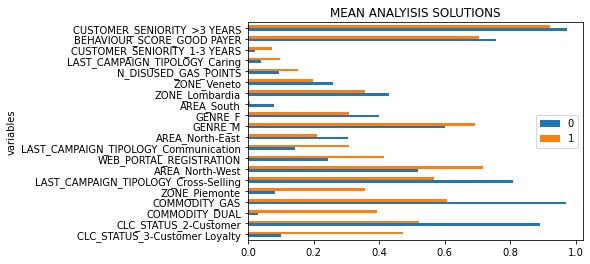

In [32]:
dataset_mean_sol = dataset_mean_sol.groupby('SOLUTIONS').mean()
dataset_mean_sol.reset_index(drop=True, inplace=True)
columns = list(dataset_mean_sol.columns)

dataset_mean_sol = dataset_mean_sol.T #transpose
dataset_mean_sol["variables"] = columns
dataset_mean_sol["difference"] = abs(dataset_mean_sol[0] - dataset_mean_sol[1])
# The results are  sorted in descending order on the basis of the difference between the means of the two groups.
sort_df = dataset_mean_sol.sort_values(by=['difference'], ascending=False)
difference_dataset = sort_df.head(20)
difference_dataset.plot(x="variables", y=[0, 1], kind="barh")
plt.title('MEAN ANALYISIS SOLUTIONS')

<AxesSubplot:ylabel='variables'>

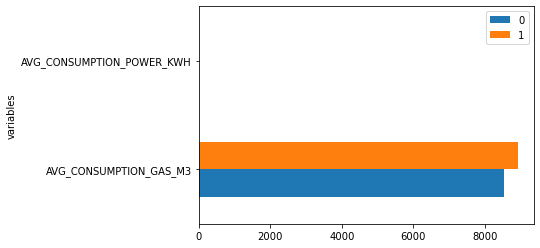

In [33]:
avg_df_mean = dataset_average_solution.groupby('SOLUTIONS').mean()
avg_df_mean.reset_index(drop=True, inplace=True)
columns2 = list(avg_df_mean.columns)
avg_df_mean = avg_df_mean.T
avg_df_mean["variables"] = columns2
avg_df_mean["difference"] = abs(avg_df_mean[0] - avg_df_mean[1])
avg_df_mean.plot(x="variables", y=[0, 1], kind="barh")

#### Mean analysis over COMMODITY_DUAL

In [34]:
df_mean_2 = dataset_with_dummies.drop(["AVG_CONSUMPTION_GAS_M3", "AVG_CONSUMPTION_POWER_KWH", 'N_DEM_CROSS_SELLING',
                           'N_SMS_CROSS_SELLING', 'N_TLS_CROSS_SELLING', 'N_DEM_SOLUTION',
                           'N_SMS_SOLUTION', 'N_TLS_SOLUTION'], axis=1)

Text(0.5, 1.0, 'MEAN ANALYISIS DUAL')

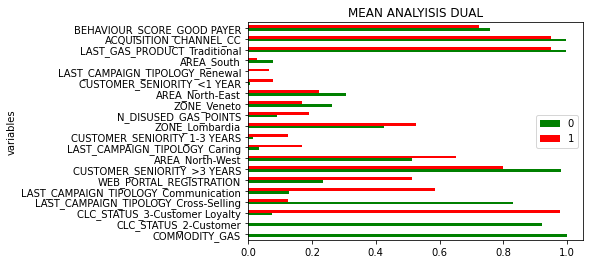

In [35]:
df_mean_2 = df_mean_2.groupby('COMMODITY_DUAL').mean()
df_mean_2.reset_index(drop=True, inplace=True)
columns = list(df_mean_2.columns)
df_mean_2 = df_mean_2.T
df_mean_2["variables"] = columns
df_mean_2["difference"] = abs(df_mean_2[0] - df_mean_2[1])
sort_df_2 = df_mean_2.sort_values(by=['difference'], ascending=False)
difference_dataset_2 = sort_df_2.head(20)
difference_dataset_2.plot(x="variables", y=[0, 1], kind="barh", color=["green", "red"])
plt.title('MEAN ANALYISIS DUAL')

<AxesSubplot:ylabel='variables'>

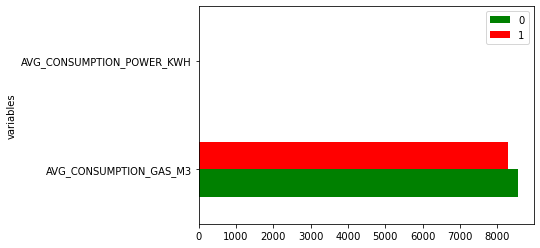

In [36]:
avg_df_mean_2 = dataset_average_dual.groupby('COMMODITY_DUAL').mean()
avg_df_mean_2.reset_index(drop=True, inplace=True)
columns2 = list(avg_df_mean_2.columns)
avg_df_mean_2 = avg_df_mean_2.T
avg_df_mean_2["variables"] = columns2
avg_df_mean_2["difference"] = abs(avg_df_mean_2[0] - avg_df_mean_2[1])
avg_df_mean_2.plot(x="variables", y=[0, 1], kind="barh", color=["green", "red"])

### Random Forest Feature importance

The feature selection is performed on the basis of the random forest feature importance, both on "COMMODITY_DUAL" and "SOLUTIONS":
- From now on the models will be trained and tested over a balanced dataset, performed [here](#undersampling)

Once again, we remove the variables belonging to the customer care interactions category

In [37]:
undersampled_commodity_dual = undersampled_commodity_dual.drop(['N_DEM_CROSS_SELLING', 'N_SMS_CROSS_SELLING',
                              'N_TLS_CROSS_SELLING', 'N_DEM_SOLUTION',
                              'N_SMS_SOLUTION', 'N_TLS_SOLUTION'], axis=1)

Define the set of (potential) independent variables

In [38]:
X = undersampled_commodity_dual.iloc[:, undersampled_commodity_dual.columns != "COMMODITY_DUAL"]

Define the dependent variable

In [39]:
y = undersampled_commodity_dual["COMMODITY_DUAL"]

Split our dataset into two sets

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Standardize features by removing the mean and scaling to unit variance

In [41]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Before actually being trained, the algorithm goes through a tuning phase in order to maximize its performance.
without overfitting or creating too high of a variance.

In [42]:
'''
rf_grid = RandomForestClassifier(random_state=0)
param_grid = {
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}
'''

"\nrf_grid = RandomForestClassifier(random_state=0)\nparam_grid = {\n    'n_estimators': [100, 500],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'max_depth': [4, 5, 6, 7, 8],\n    'criterion': ['gini', 'entropy']\n}\n"

Each combination’s performance is then evaluated using cross-validation and the best performing hyperparametric combination is chosen.

In [43]:
'''
CV_rfc = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
'''

'\nCV_rfc = GridSearchCV(estimator=rf_grid, param_grid=param_grid, cv=5)\nCV_rfc.fit(X_train, y_train)\nprint(CV_rfc.best_params_)\n'

Fit the model with the best performing hyperparametric combination

In [44]:
rf_features = RandomForestClassifier(random_state=0, max_features='auto', n_estimators=500, max_depth=7, criterion='gini')
rf_features.fit(X_train, y_train)
y_pred = rf_features.predict(X_test)

Evaluate the model

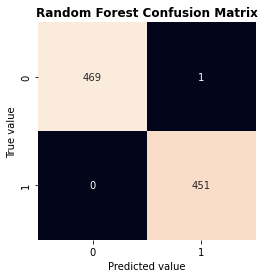

In [45]:
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Random Forest Confusion Matrix", fontweight="bold", fontsize=12)
plt.show()

In [46]:
accuracy_train = rf_features.score(X_train, y_train)
print("Random Forest - Accuracy on the training set: " + str(accuracy_train))
print("Random Forest - Accuracy on the test set: " + str(accuracy_score(y_test, y_pred)))
print("Random Forest - Precision: " + str(precision_score(y_test, y_pred)))
print("Random Forest - Recall: " + str(recall_score(y_test, y_pred)))

Random Forest - Accuracy on the training set: 1.0
Random Forest - Accuracy on the test set: 0.998914223669924
Random Forest - Precision: 0.9977876106194691
Random Forest - Recall: 1.0


Visualize how much each variable is contributing to the decision.

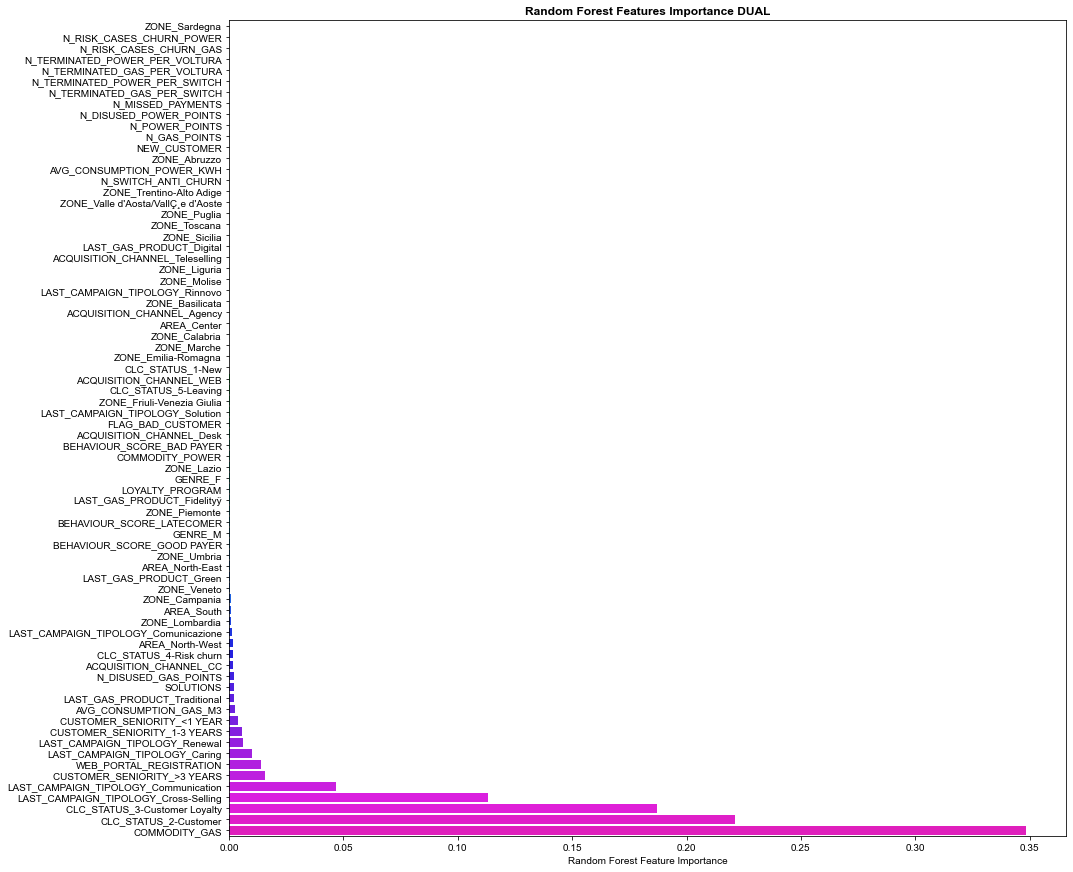

In [47]:
sorted_idx = rf_features.feature_importances_.argsort()
yaxis1 = pd.DataFrame(X)

plt.figure(figsize=(15, 15))
sns.barplot(x=rf_features.feature_importances_[sorted_idx], y=yaxis1.columns[sorted_idx], orient="h",
            palette="gist_rainbow")
plt.xlabel("Random Forest Feature Importance")
plt.title("Random Forest Features Importance DUAL", fontweight="bold", fontsize=12)
sns.set(font_scale=0.3)
plt.rcParams['figure.dpi'] = 300
plt.show()

Interestingly, the results deriving from the "mean analysis" have been almost completely confirmed.

### Feature importance over "SOLUTIONS"

The same procedure done before is performed in relation with the independent variable "SOLUTIONS".

In [48]:
undersampled_solution = undersampled_solution.drop(['N_DEM_CROSS_SELLING', 'N_SMS_CROSS_SELLING',
                                                    'N_TLS_CROSS_SELLING', 'N_DEM_SOLUTION',
                                                    'N_SMS_SOLUTION', 'N_TLS_SOLUTION'], axis=1)
undersampled_solution = undersampled_solution.dropna(axis=0)

In [49]:
X_sol = undersampled_solution.iloc[:, undersampled_solution.columns != "SOLUTIONS"]
y_sol = undersampled_solution["SOLUTIONS"]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_sol, y_sol, test_size=0.3, random_state=0)

In [51]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [52]:
#GRID SEARCH
'''
rf_final_sol = RandomForestClassifier(0)
param_grid = {
    'n_estimators': [20, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}
CV_rfc_sol = GridSearchCV(estimator=rf_final_sol, param_grid=param_grid, cv=5)
CV_rfc_sol.fit(X_train, y_train)
print(CV_rfc_sol.best_params_)
'''

"\nrf_final_sol = RandomForestClassifier(0)\nparam_grid = {\n    'n_estimators': [20, 500],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'max_depth': [3, 4, 5, 6, 7, 8],\n    'criterion': ['gini', 'entropy']\n}\nCV_rfc_sol = GridSearchCV(estimator=rf_final_sol, param_grid=param_grid, cv=5)\nCV_rfc_sol.fit(X_train, y_train)\nprint(CV_rfc_sol.best_params_)\n"

In [53]:
rfc_feature_solution = RandomForestClassifier(random_state=0, max_features='log2', n_estimators=20, max_depth=6, criterion='entropy')
rfc_feature_solution.fit(X_train, y_train)
y_pred = rfc_feature_solution.predict(X_test)

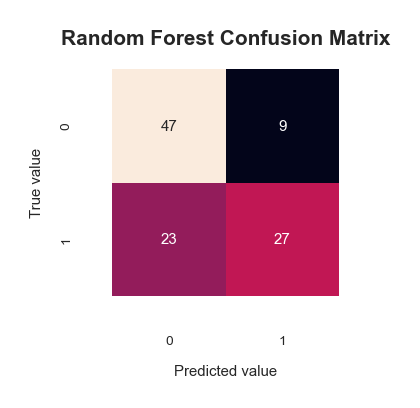

In [54]:
# Evaluation metrics
mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(1,1))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.title("Random Forest Confusion Matrix", fontweight="bold", fontsize= 5)
plt.show()

In [55]:
accuracy_train = rfc_feature_solution.score(X_train, y_train)
print("Random Forest - Accuracy on the training set: " + str(accuracy_train))
print("Random Forest - Accuracy on the test set: " + str(accuracy_score(y_test, y_pred)))
print("Random Forest - Precision: " + str(precision_score(y_test, y_pred)))
print("Random Forest - Recall: " + str(recall_score(y_test, y_pred)))

Random Forest - Accuracy on the training set: 0.8211382113821138
Random Forest - Accuracy on the test set: 0.6981132075471698
Random Forest - Precision: 0.75
Random Forest - Recall: 0.54


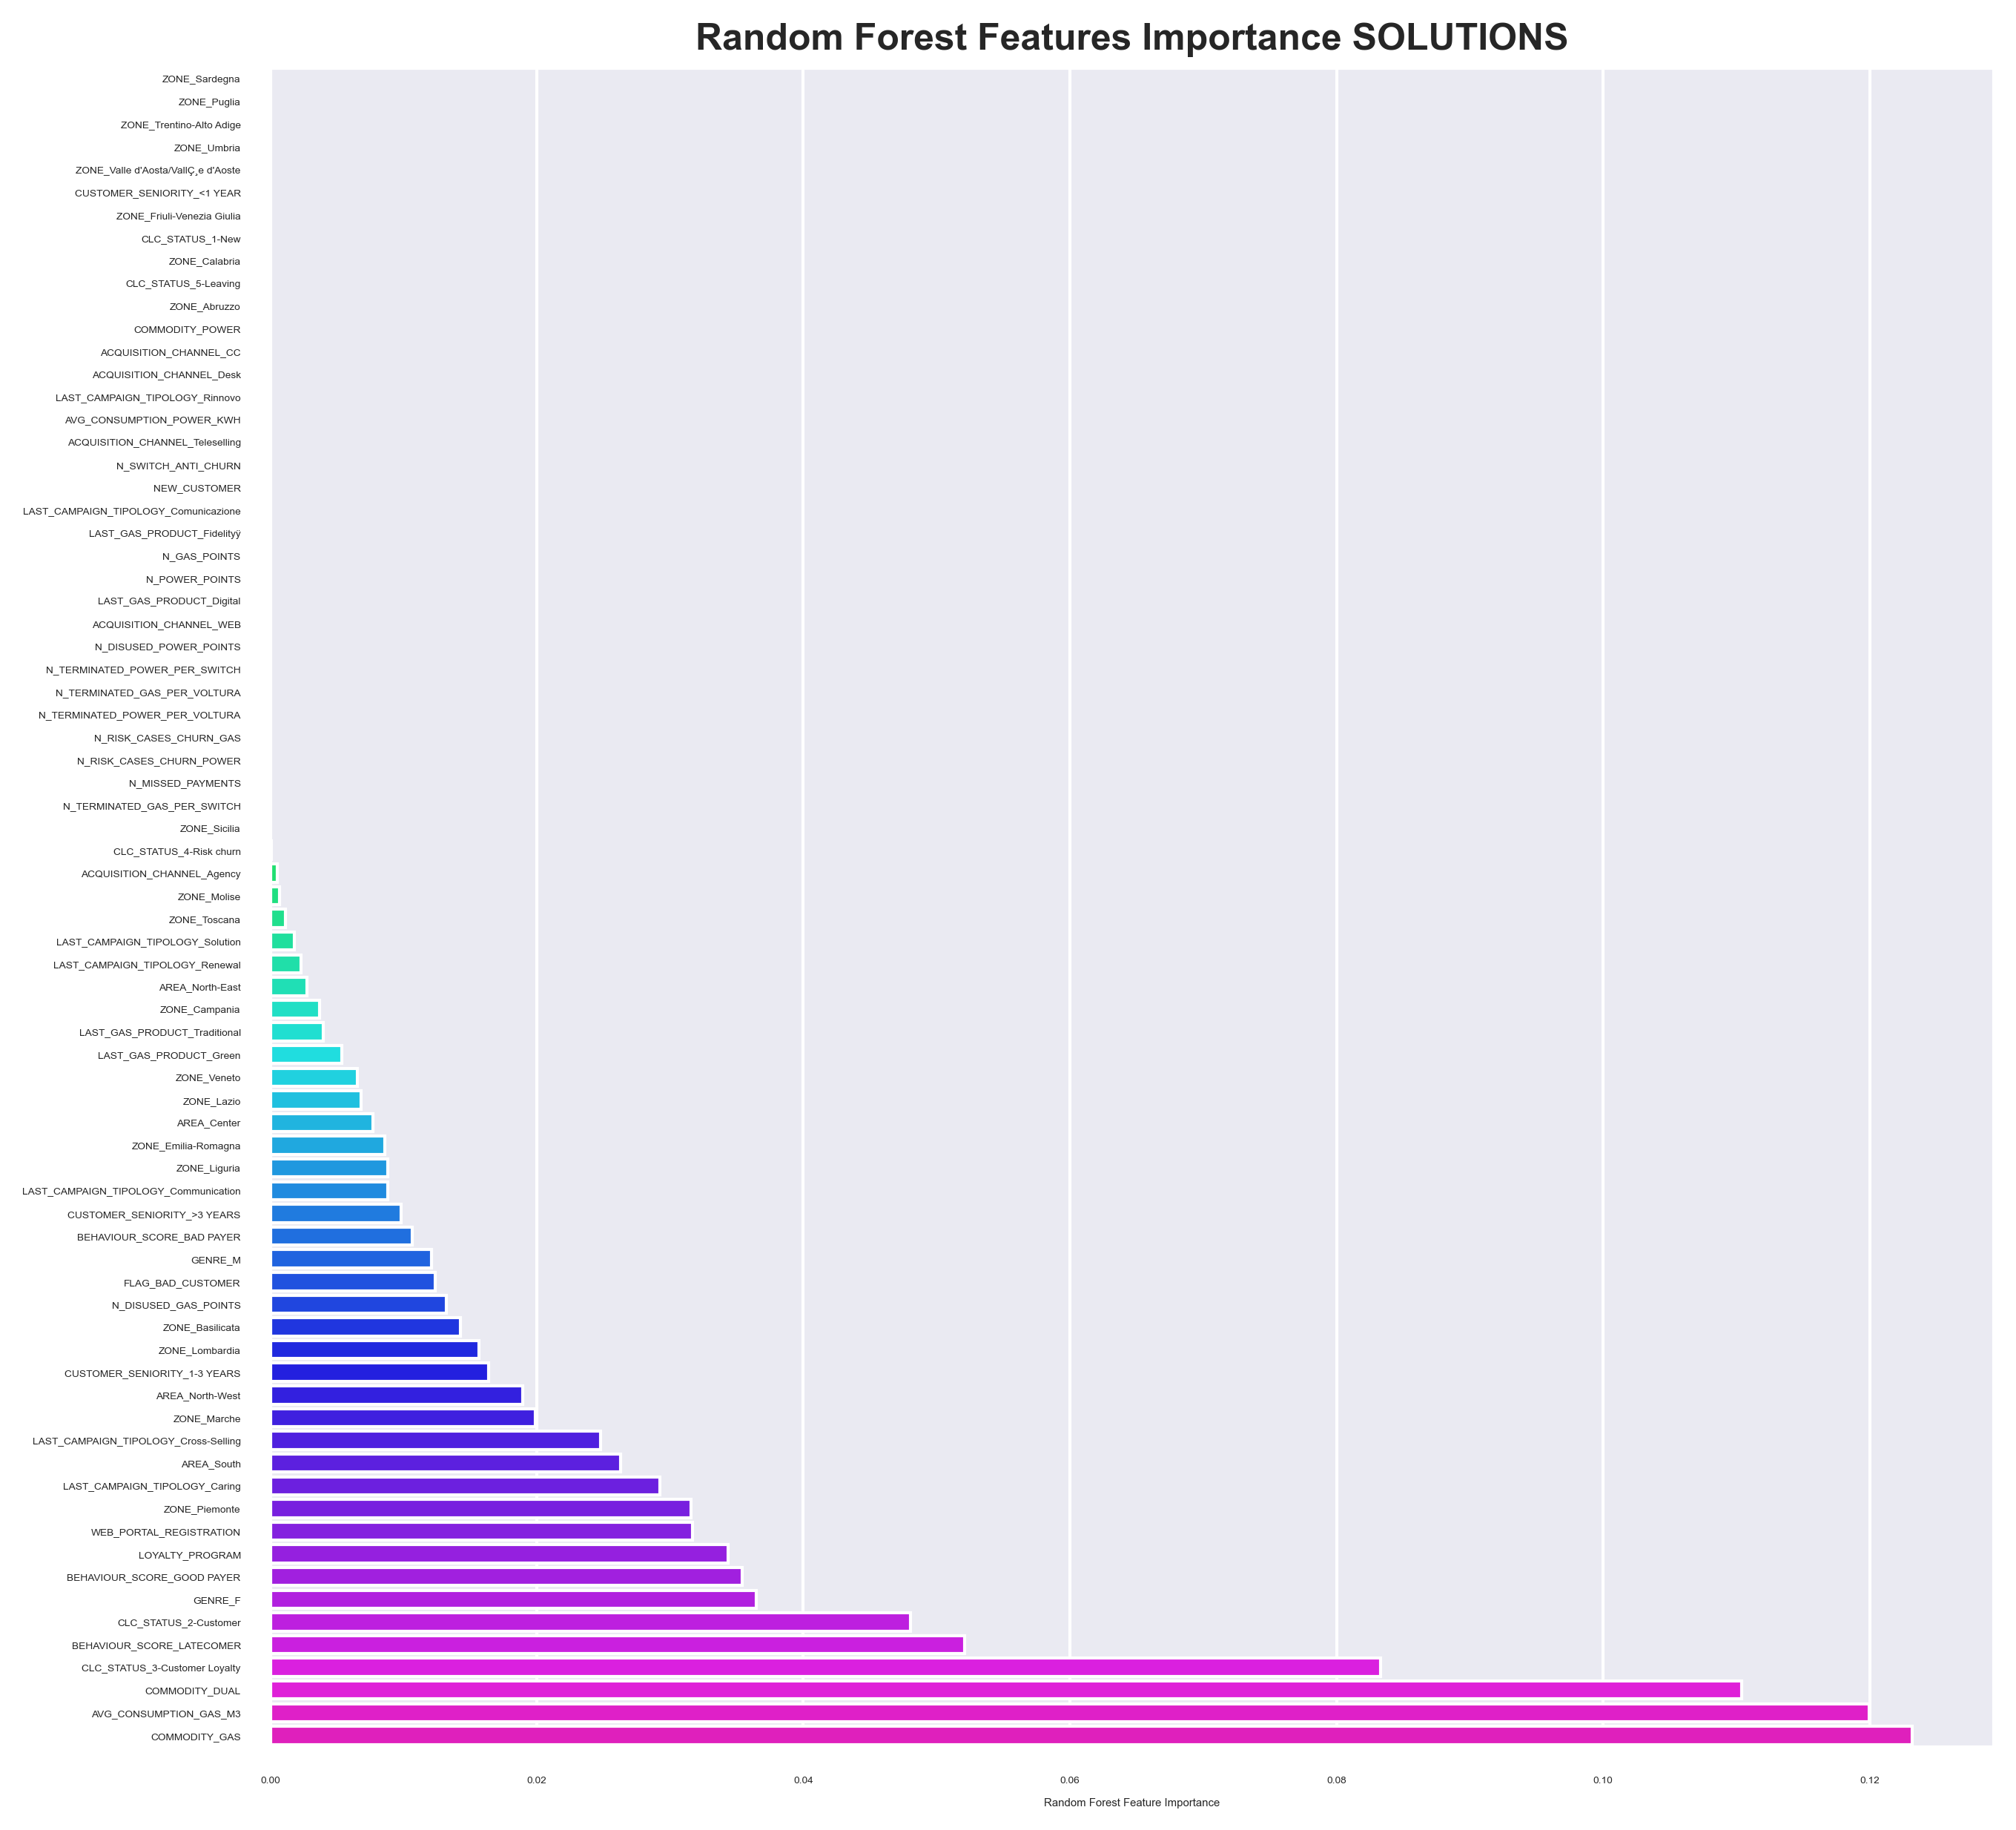

In [56]:
sorted_idx = rfc_feature_solution.feature_importances_.argsort()
yaxis1 = pd.DataFrame(X_sol)

plt.figure(figsize=(10, 10))
sns.barplot(x=rfc_feature_solution.feature_importances_[sorted_idx], y=yaxis1.columns[sorted_idx], orient="h",
            palette="gist_rainbow")
plt.xlabel("Random Forest Feature Importance")
plt.title("Random Forest Features Importance SOLUTIONS", fontweight="bold", fontsize=12)
sns.set(font_scale=0.3)
plt.rcParams['figure.dpi'] = 100
plt.show()

## ELIGIBILITY DATASETS DUAL

Create the set of predictors on the basis of the results obtained from the feature selection.

The variables that lack of an economic meaning, together with the strongly correlated ones (e.g. the dummy variables deriving from the same original feature), are removed

The variables that would have helped us to identify non-elegible customers (e.g. "CONSENSUS_PRIVACY" and "PHONE_VALIDATED") have been added

In [57]:
different_cols = dataset_with_dummies.columns.difference(dataset_clean.columns)
dataset_difference = dataset_with_dummies[different_cols]

dataset_whole = pd.merge(dataset_clean, dataset_difference, left_index=True,
                         right_index=True, how='inner')

dataset_dual = dataset_whole.filter(['CLC_STATUS_3-Customer Loyalty', 'AREA_North-West', 'WEB_PORTAL_REGISTRATION',
                                     'LAST_CAMPAIGN_TIPOLOGY_Cross-Selling',
                                     'N_DISUSED_GAS_POINTS',
                                     'LAST_CAMPAIGN_TIPOLOGY_Caring', 'SOLUTIONS', 'CUSTOMER_SENIORITY_>3 YEARS',
                                     'LAST_CAMPAIGN_TIPOLOGY_Renewal',
                                     'CUSTOMER_SENIORITY_1-3 YEARS', 'AVG_CONSUMPTION_GAS_M3',
                                     'LAST_GAS_PRODUCT_Traditional',
                                     "CONSENSUS_PRIVACY", "ID", "COMMODITY_DUAL", "PHONE_VALIDATED", "EMAIL_VALIDATED"],
                                      axis=1)

## Propensity models on "COMMODITY_DUAL"

Constitute a dataset made up of non-eligible customers

In [58]:
def non_eligible(df):
    df = df.drop(df[(df["CONSENSUS_PRIVACY"] == "YES") & (df["COMMODITY_DUAL"] == 0)].index)
    return df
dataset_non_eligible = non_eligible(dataset_dual)
dataset_non_eligible = dataset_non_eligible.dropna(axis=0)

Constitute a dataset made up of eligible customers

In [59]:
def eligible(df):
    df = df.drop(df[(df["CONSENSUS_PRIVACY"] == "NO") | (df["COMMODITY_DUAL"] == 1)].index)
    df = df.drop(df[(df["PHONE_VALIDATED"] == "KO") & (df["EMAIL_VALIDATED"] == 0)].index)
    return df
dataset_eligible = eligible(dataset_dual)
dataset_eligible = dataset_eligible.dropna(axis=0)

The training set and the test set derive from **dataset_non_elegible**.
Therefore, also in this case, we perform a random undersampling

In [60]:
class_2, class_1 = dataset_non_eligible.COMMODITY_DUAL.value_counts()
c2 = dataset_non_eligible[dataset_non_eligible['COMMODITY_DUAL'] == 0]
c1 = dataset_non_eligible[dataset_non_eligible['COMMODITY_DUAL'] == 1]

import random
df_2 = c2.sample(class_1,random_state=43)
under_dual = pd.concat([df_2, c1], axis=0)

In [61]:
under_dual.value_counts("COMMODITY_DUAL")

COMMODITY_DUAL
0    1842
1    1842
dtype: int64

## MODELS

#### Models with as target variable (y) the feature "COMMODITY_DUAL"

In [62]:
X = under_dual.iloc[:, :-5].values # set the X dataset
y = under_dual["COMMODITY_DUAL"]   # target variable

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [64]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [65]:
rf = RandomForestClassifier(random_state=0, max_features='auto', n_estimators=100,
                                     max_depth=8, criterion='gini')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy_train = rf.score(X_train, y_train)
print("Random Forest - Accuracy on the training set: " + str(accuracy_train))
print("Random Forest - Accuracy on the test set: " + str(accuracy_score(y_test, y_pred)))
print("Random Forest - Precision: " + str(precision_score(y_test, y_pred)))
print("Random Forest - Recall: " + str(recall_score(y_test, y_pred)))

Random Forest - Accuracy on the training set: 0.8933281613653995
Random Forest - Accuracy on the test set: 0.8933092224231465
Random Forest - Precision: 0.8377952755905512
Random Forest - Recall: 0.9725776965265083


In [66]:
X_pred = dataset_eligible.iloc[:, :-5].values
X_pred = sc.transform(X_pred)
predicted = rf.predict_proba(X_pred)
predicted = pd.DataFrame(predicted)
predicted['RANDOM PREDICTION'] = np.where(predicted[0] >= 0.5, 0, 1)
dataset_eligible['RANDOM PREDICTION'] = predicted['RANDOM PREDICTION'].values

In [67]:
ensemble = pd.DataFrame(y_test)
ensemble['RANDOM PREDICTION'] = pd.Series(y_pred).values

## KNN

In [68]:
knn_model_dual = KNeighborsClassifier(n_neighbors=19)
knn_model_dual.fit(X_train, y_train)
y_pred_knn_dual = knn_model_dual.predict(X_test)

In [69]:
accuracy_train = knn_model_dual.score(X_train, y_train)
print("KNN - Accuracy on the training set: " + str(accuracy_train))
print("KNN - Accuracy on the test set: " + str(accuracy_score(y_test, y_pred_knn_dual)))
print("KNN - Precision: " + str(precision_score(y_test, y_pred_knn_dual)))
print("KNN - Recall: " + str(recall_score(y_test, y_pred_knn_dual)))

KNN - Accuracy on the training set: 0.8762606671838634
KNN - Accuracy on the test set: 0.8842676311030742
KNN - Precision: 0.8268330733229329
KNN - Recall: 0.9689213893967094


Since we need the probability of the event besides its classification,
in the case of KNN (and later also of SVC) we recurr to calibrated probabilities.

In [70]:
calib_clf_dual = CalibratedClassifierCV(knn_model_dual, cv=3, method='sigmoid') # fit and calibrate model on training data
calib_clf_dual.fit(X_train, y_train)
y_calibprob_dual = calib_clf_dual.predict_proba(X_test)  #evaluate the model
y_calibprob_dual = pd.DataFrame(y_calibprob_dual)
y_test_dual = pd.DataFrame(y_test)
predicted_knn_dual = pd.concat([y_calibprob_dual.reset_index(drop=True), y_test_dual.reset_index(drop=True)], axis=1)
predicted_knn_dual['predicted'] = np.where(predicted_knn_dual[0] >= 0.5, 0, 1)

confusion_matrix_dual = pd.crosstab(predicted_knn_dual['COMMODITY_DUAL'],
                                    predicted_knn_dual['predicted'],
                                    rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix_dual)

Predicted    0    1
Actual             
0          454  105
1           19  528


In [71]:
pred_dual = calib_clf_dual.predict_proba(X_pred)
pred_dual = pd.DataFrame(pred_dual)
ID_column = dataset_eligible["ID"]
pred_dual = pd.concat([pred_dual, ID_column.reset_index(drop=True)], axis=1)

pred_dual['KNN PREDICTION'] = np.where(pred_dual[0] >= 0.5, 0, 1)
ensemble['KNN PREDICTION'] = predicted_knn_dual['predicted'].values

### SVM

Also for the svm the calibrarted model is used in order to have probabilities as output

In [72]:
svm = SVC(C=1, coef0=0.01, degree=3, gamma='auto', kernel='rbf')
svm.fit(X_train, y_train)
prediction_svm = svm.predict(X_test)

In [73]:
clf = CalibratedClassifierCV(svm, cv=3)
clf.fit(X_train, y_train)
y_proba = clf.predict_proba(X_test)
y_proba = pd.DataFrame(y_proba)
y_proba['SVM PREDICTION'] = np.where(y_proba[0] >= 0.5, 0, 1)

In [74]:
accuracy_train = svm.score(X_train, y_train)
print("Accuracy on the training set: " + str(accuracy_train))
print("Accuracy on the test set: " + str(accuracy_score(y_test, prediction_svm)))
print("Precision: " + str(precision_score(y_test, prediction_svm)))
print("Recall: " + str(recall_score(y_test, prediction_svm)))

Accuracy on the training set: 0.8851823118696664
Accuracy on the test set: 0.8987341772151899
Precision: 0.8457869634340223
Recall: 0.9725776965265083


In [75]:
pred_dual_svm = clf.predict_proba(X_pred)
pred_dual_svm = pd.DataFrame(pred_dual_svm)
pred_dual_svm['ID'] = dataset_eligible['ID'].values

In [76]:
pred_dual_svm['SVM PREDICTION'] = np.where(pred_dual_svm[0] >= 0.5, 0, 1)
ensemble['SVM PREDICTION'] = y_proba['SVM PREDICTION'].values

### LOGISTIC REGRESSION

The output of a logistic regressions is a calibrated probability.

In [77]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train.values.ravel())
y_pred_log = log_reg.predict(X_test)
y_pred_log = pd.DataFrame(y_pred_log)

In [78]:
accuracy_train = log_reg.score(X_train, y_train)
print("Accuracy on the training set: " + str(accuracy_train))
print("Accuracy on the test set: " + str(accuracy_score(y_test, y_pred_log)))
print("Precision: " + str(precision_score(y_test, y_pred_log)))
print("Recall: " + str(recall_score(y_test, y_pred_log)))

Accuracy on the training set: 0.8828549262994569
Accuracy on the test set: 0.8960216998191681
Precision: 0.8428571428571429
Recall: 0.9707495429616088


In [79]:
pred_dual_log = log_reg.predict_proba(X_pred)
pred_dual_log = pd.DataFrame(pred_dual_log)
pred_dual_log['ID'] = dataset_eligible['ID'].values
pred_dual_log['LOG PREDICTION'] = np.where(pred_dual_log[0] >= 0.5, 0, 1)

In [80]:
ensemble['LOG PREDICTION'] = y_pred_log[0].values

### ENSAMBLE

Through the use of the "VotingClassifier" an esamble method with the models done so far is created.

In [81]:
eclf_dual = VotingClassifier(
    estimators=[('Random Forest', rf), ('KNN', calib_clf_dual), ('SVM', clf), ('Logistic Regression', log_reg)],
    voting='soft')
eclf_dual = eclf_dual.fit(X_train, y_train)
print(eclf_dual.predict(X_test))

[1 1 1 ... 1 1 0]


In [82]:
y_proba_ens = eclf_dual.predict_proba(X_test)
y_proba_ens = pd.DataFrame(y_proba_ens)
y_proba_ens['ENSEMBLE PREDICTION'] = np.where(y_proba_ens[0] >= 0.5, 0, 1)
ensemble['ENSEMBLE PREDICTION'] = y_proba_ens['ENSEMBLE PREDICTION'].values
pd.crosstab(ensemble['COMMODITY_DUAL'], ensemble['ENSEMBLE PREDICTION'])

ENSEMBLE PREDICTION,0,1
COMMODITY_DUAL,,
0,464,95
1,15,532


Since it is the ensemble that has the highest performance, we choose this to predict who will sign the contract and who will not

In [83]:
predictions = eclf_dual.predict_proba(X_pred)
predictions = pd.DataFrame(predictions)
predictions['ID'] = dataset_eligible['ID'].values
predictions['PREDICTION_DUAL'] = np.where(predictions[0] >= 0.5, 0, 1)

In [84]:
predictions = predictions.drop([0, 1], axis=1)

- Perform a left join between dataset and predictions on the basis of "ID", returning a dataframe containing all the rows of the left dataframe (dataset)
- All the non-matching rows of the left dataframe contain NaN for the columns in the right dataframe. (the customers non eligibles)

In [85]:
dataset_clean = dataset_clean.merge(predictions, how='left', left_on='ID', right_on='ID')

In [86]:
dataset_clean[["PREDICTION_DUAL"]]

,PREDICTION_DUAL
0,0.0
1,NaN
2,0.0
3,0.0
4,0.0
...,...
60573,0.0
60574,0.0
60575,0.0
60576,0.0


### PROPENSITY MODELS ON "SOLUTIONS"

The propensity over the independent variable "SOLUTIONS" is performed in the following code. Similarly to the one over "DUAL".

In [87]:
def non_eligible_sol(df):
    df = df.drop(df[(df["CONSENSUS_PRIVACY"] == "YES") & (df["SOLUTIONS"] == 0)].index)
    return df

def eligible_sol(df):
    df = df.drop(df[(df["CONSENSUS_PRIVACY"] == "NO") | (df["SOLUTIONS"] == 1)].index)
    df = df.drop(df[(df["PHONE_VALIDATED"] == "KO") & (df["EMAIL_VALIDATED"] == 0)].index)
    return df

In [88]:
dataset_sol = dataset_whole.filter(
    ['AVG_CONSUMPTION_GAS_M3', "COMMODITY_DUAL", 'ZONE_Piemonte', 'WEB_PORTAL_REGISTRATION',
     'AREA_North-West', 'CLC_STATUS_3-Customer Loyalty', 'BEHAVIOUR_SCORE_GOOD PAYER', 'LOYALTY_PROGRAM', 'AREA_SOUTH',
     'ZONE_VENETO',
     'LAST_CAMPAIGN_TIPOLOGY_Caring', 'AREA_North-East',
     'LAST_CAMPAIGN_TIPOLOGY_Cross-Selling', 'CUSTOMER_SENIORITY_>3 YEARS', 'CUSTOMER_SENIORITY_<1 YEAR',
     'ACQUISITION_CHANNEL_CC', 'BEHAVIOUR_SCORE_BAD PAYER', "AREA_CENTER", "CONSENSUS_PRIVACY", "ID"
        , "PHONE_VALIDATED", "EMAIL_VALIDATED", "SOLUTIONS"], axis=1)

In [89]:
dataset_eligib_sol = eligible_sol(dataset_sol)
dataset_non_eligib_sol = non_eligible_sol(dataset_sol)

dataset_eligib_sol.dropna(axis=0, inplace=True)
dataset_non_eligib_sol.dropna(axis=0, inplace=True)

In [90]:
class_2, class_1 = dataset_non_eligib_sol.SOLUTIONS.value_counts()
c2 = dataset_non_eligib_sol[dataset_non_eligib_sol['SOLUTIONS'] == 0]
c1 = dataset_non_eligib_sol[dataset_non_eligib_sol['SOLUTIONS'] == 1]
df_3 = c2.sample(class_1, random_state=23)
under_sol = pd.concat([df_3, c1], axis=0)

In [91]:
under_sol.value_counts("SOLUTIONS")

SOLUTIONS
0    176
1    176
dtype: int64

Set the independent variables (X_sol) and dependent one (y_sol)

In [92]:
X_sol = under_sol.iloc[:, :-5].values
y_sol = under_sol["SOLUTIONS"]

In [93]:
X_train_sol, X_test_sol, y_train_sol, y_test_sol = train_test_split(X_sol, y_sol, test_size=0.3, random_state=0)

In [94]:
sc = StandardScaler()
X_train_sol = sc.fit_transform(X_train_sol)
X_test_sol = sc.transform(X_test_sol)

### Random Forest

In [95]:
rfc_feature_solution = RandomForestClassifier(random_state=0, max_features='auto', n_estimators=105,
                                              max_depth=4, criterion='gini')
rfc_feature_solution.fit(X_train_sol, y_train_sol)
y_pred_sol = rfc_feature_solution.predict(X_test_sol)
y_pred_sol = pd.DataFrame(y_pred_sol)

In [96]:
accuracy_train = rfc_feature_solution.score(X_train_sol, y_train_sol)
print("Random Forest - Accuracy on the training set: " + str(accuracy_train))
print("Random Forest - Accuracy on the test set: " + str(accuracy_score(y_test_sol, y_pred_sol)))
print("Random Forest - Precision: " + str(precision_score(y_test_sol, y_pred_sol)))
print("Random Forest - Recall: " + str(recall_score(y_test_sol, y_pred_sol)))

Random Forest - Accuracy on the training set: 0.7845528455284553
Random Forest - Accuracy on the test set: 0.6792452830188679
Random Forest - Precision: 0.6666666666666666
Random Forest - Recall: 0.64


In [97]:
X_pred_sol = dataset_eligib_sol.iloc[:, :-5].values
X_pred_sol = sc.transform(X_pred_sol)

In [98]:
ensemble_sol = pd.DataFrame(y_test_sol)
ensemble_sol['RANDOM PREDICTION'] = y_pred_sol[0].values

## SVM
Support Vector Machine

In [99]:
svm = SVC(C=1, coef0=0.5, degree=3, gamma='auto', kernel='poly')
svm.fit(X_train_sol, y_train_sol)
prediction_svm = svm.predict(X_test_sol)

In [100]:
accuracy_train = svm.score(X_train_sol, y_train_sol)
print("Accuracy on the training set: " + str(accuracy_train))
print("Accuracy on the test set: " + str(accuracy_score(y_test_sol, prediction_svm)))
print("Precision: " + str(precision_score(y_test_sol, prediction_svm)))
print("Recall: " + str(recall_score(y_test_sol, prediction_svm)))

Accuracy on the training set: 0.8130081300813008
Accuracy on the test set: 0.6981132075471698
Precision: 0.7045454545454546
Recall: 0.62


In [101]:
svm = SVC(C=1, coef0=0.5, degree=3, gamma='auto', kernel='poly')
clf_sol = CalibratedClassifierCV(svm, cv=3)
clf_sol.fit(X_train_sol, y_train_sol)
y_proba_sol = clf_sol.predict_proba(X_test_sol)
y_proba_sol = pd.DataFrame(y_proba_sol)
y_test_sol = pd.DataFrame(y_test_sol)

y_proba_sol['SVM PREDICTION'] = np.where(y_proba_sol[0] >= 0.5, 0, 1)
ensemble_sol['SVM PREDICTION'] = y_proba_sol['SVM PREDICTION'].values

## LOGISTIC REGRESSION

In [102]:
mod_log_sol = LogisticRegression()
mod_log_sol.fit(X_train_sol, y_train_sol.values.ravel())
mod_pred_log = mod_log_sol.predict(X_test_sol)

In [103]:
print("Accuracy on the test set: " + str(accuracy_score(y_test_sol, mod_pred_log)))
print("Precision: " + str(precision_score(y_test_sol, mod_pred_log)))
print("Recall: " + str(recall_score(y_test_sol, mod_pred_log)))

Accuracy on the test set: 0.7169811320754716
Precision: 0.7
Recall: 0.7


In [104]:
mod_pred_log = pd.DataFrame(mod_pred_log)
ensemble_sol['LOG PREDICTION'] = mod_pred_log[0].values

## KNN

In [105]:
knn_model_sol = KNeighborsClassifier(n_neighbors=9)
knn_model_sol.fit(X_train_sol, y_train_sol)
y_pred_knn_sol = knn_model_sol.predict(X_test_sol)

In [106]:
accuracy_train = knn_model_sol.score(X_train_sol, y_train_sol)
print("KNN - Accuracy on the training set: " + str(accuracy_train))
print("KNN - Accuracy on the test set: " + str(accuracy_score(y_test_sol, y_pred_knn_sol)))
print("KNN - Precision: " + str(precision_score(y_test_sol, y_pred_knn_sol)))
print("KNN - Recall: " + str(recall_score(y_test_sol, y_pred_knn_sol)))

KNN - Accuracy on the training set: 0.7479674796747967
KNN - Accuracy on the test set: 0.7641509433962265
KNN - Precision: 0.7272727272727273
KNN - Recall: 0.8


In [107]:
calib_clf_sol = CalibratedClassifierCV(knn_model_sol, cv=3, method='sigmoid')
calib_clf_sol.fit(X_train_sol, y_train_sol)
y_calibprob_sol = calib_clf_sol.predict_proba(X_test_sol)
y_calibprob_sol = pd.DataFrame(y_calibprob_sol)
y_test_sol = pd.DataFrame(y_test_sol)
predicted_knn_sol = pd.concat([y_calibprob_sol.reset_index(drop=True), y_test_sol.reset_index(drop=True)], axis=1)
predicted_knn_sol['predicted'] = np.where(predicted_knn_sol[0] >= 0.5, 0, 1)
ensemble_sol['KNN PREDICTION'] = predicted_knn_sol['predicted'].values

## ENSAMBLE

In [108]:
eclf_sol = VotingClassifier(estimators=[('Random Forest', rfc_feature_solution), ('KNN', calib_clf_sol), ('SVM', clf_sol),
                                        ('Logistic Regression', mod_log_sol)], voting='soft')
eclf_sol = eclf_sol.fit(X_train_sol, y_train_sol)

y_proba_ens_sol = eclf_sol.predict_proba(X_test_sol)
y_proba_ens_sol = pd.DataFrame(y_proba_ens_sol)
y_proba_ens_sol['ENSEMBLE PREDICTION'] = np.where(y_proba_ens_sol[0] >= 0.5, 0, 1)
ensemble_sol['ENSEMBLE PREDICTION'] = y_proba_ens_sol['ENSEMBLE PREDICTION'].values
pd.crosstab(ensemble_sol['SOLUTIONS'], ensemble_sol['ENSEMBLE PREDICTION'])

ENSEMBLE PREDICTION,0,1
SOLUTIONS,,
0,40,16
1,14,36


In [109]:
predictions_sol = eclf_sol.predict_proba(X_pred_sol)
predictions_sol = pd.DataFrame(predictions_sol)
predictions_sol['ID'] = dataset_eligib_sol['ID'].values
predictions_sol['PREDICTION_SOL'] = np.where(predictions_sol[0] >= 0.5, 0, 1)

In [110]:
predictions_sol = predictions_sol.drop([0, 1], axis=1)

In [111]:
dataset_clean = dataset_clean.merge(predictions_sol, how='left', left_on='ID', right_on='ID')

In [112]:
dataset_clean.head()

,ID,GENRE,CONSENSUS_PRIVACY,LOYALTY_PROGRAM,DATE_LAST_VISIT_DESK,DATE_LAST_REQUEST_CC,SOLUTIONS,COMMODITY,ZONE,NEW_CUSTOMER,...,N_DEM_CROSS_SELLING,N_SMS_CROSS_SELLING,N_TLS_CROSS_SELLING,N_DEM_SOLUTION,N_SMS_SOLUTION,N_TLS_SOLUTION,AVG_CONSUMPTION_GAS_M3,AVG_CONSUMPTION_POWER_KWH,PREDICTION_DUAL,PREDICTION_SOL
0,10,M,YES,1,NaN,01/12/2020,0,GAS,Veneto,0,...,0.0,0.0,1.0,0.0,0.0,0.0,2760.0,0.0,0.0,0.0
1,20,F,NO,1,NaN,01/08/2017,0,GAS,Lombardia,0,...,0.0,0.0,0.0,0.0,0.0,0.0,12620.0,0.0,NaN,NaN
2,22,F,YES,0,NaN,NaN,0,GAS,Emilia-Romagna,0,...,0.0,0.0,1.0,0.0,0.0,0.0,14670.0,0.0,0.0,1.0
3,26,M,YES,1,NaN,01/10/2015,0,GAS,Lombardia,0,...,0.0,0.0,1.0,0.0,0.0,0.0,830.0,0.0,0.0,0.0
4,32,F,YES,0,NaN,01/09/2020,0,GAS,Lombardia,0,...,0.0,0.0,1.0,0.0,0.0,0.0,5130.0,0.0,0.0,0.0


Check how many customers have been categorized as likely to sign the contract for each category.

In [113]:
dataset_clean.value_counts('PREDICTION_SOL')

PREDICTION_SOL
0.0    28505
1.0     9995
dtype: int64

In [114]:
dataset_clean.value_counts('PREDICTION_DUAL')

PREDICTION_DUAL
0.0    37965
1.0      243
dtype: int64

### ELIGIBILITY

Create the dataset in which monthly contact strategies will be inserted

In [115]:
column_names = ["ID", "Month_1", "Month_2", "Month_3", "Month_4", "Month_5", "Month_6",
                "Month_7", "Month_8", "Month_9", "Month_10", "Month_11", "Month_12"]
Cross_Selling_DEM = pd.DataFrame(columns=column_names)
Cross_Selling_SMS = pd.DataFrame(columns=column_names)
Cross_Selling_TLS = pd.DataFrame(columns=column_names)
Solution_DEM = pd.DataFrame(columns=column_names)
Solution_SMS = pd.DataFrame(columns=column_names)
Solution_TLS = pd.DataFrame(columns=column_names)

Clean for CONSENSUS_PRIVACY, CLC_STATUS

In [116]:
def clean_data_for_eligibility(df):
    df = df.drop(df[df["CLC_STATUS"] == "4-Risk churn"].index)
    df2 = df.drop(df[df["CLC_STATUS"] == "5-Leaving"].index)
    df3 = df.drop(df[df["CONSENSUS_PRIVACY"] == "NO"].index)
    return df3


dataset_eligible = clean_data_for_eligibility(dataset_clean)

Clean for EMAIL_VALIDATED and PHONE_VALIDATE

In [117]:
def clean_phone(df):
    df = df.drop(df[(df["PHONE_VALIDATED"] == "KO") & (df["EMAIL_VALIDATED"] == 0)].index)
    return df


dataset_final_eligible = clean_phone(dataset_eligible)

DIVIDING DATASET ACCORDING TO THE ELIGIBILITY

Filtering the costumers chosen by the propensity model on the basis of the "general rule": Those customers whose last contact dates back to at least N months ago are eligible, where N = # months / # contacts per year.

In [118]:
pd.options.mode.chained_assignment = None
timefmt = "%d/%m/%Y" # set dates format
dataset_final_eligible['DATE_LAST_CAMPAIGN'] = pd.to_datetime(dataset_final_eligible['DATE_LAST_CAMPAIGN'],
                                                              format=timefmt)

datatypes = dataset_final_eligible.dtypes

dataset_final_eligible['REFERENCE_DATE'] = "26/04/2022" # as reference date we take the day on which the project was delivered
dataset_final_eligible['REFERENCE_DATE'] = pd.to_datetime(dataset_final_eligible['REFERENCE_DATE'], format=timefmt)

dataset_final_eligible['N_months'] = (
        (dataset_final_eligible.DATE_LAST_CAMPAIGN - dataset_final_eligible.REFERENCE_DATE) / np.timedelta64(1,
                                                                                                             'M'))# compute the difference between the reference date and the date on which the last contact took place
dataset_final_eligible['N_months'] = dataset_final_eligible['N_months'].astype(int).abs() # compute the absolute value of the result

Create six subset of dataset_final_eligible (ne for every possible combination of marketing campaign and communication channel) on the basis of which the monthly contact strategies will be defined

In [119]:

cross_selling_tls_general = dataset_final_eligible[
    (dataset_final_eligible.N_months >= 6) & (dataset_final_eligible["PHONE_VALIDATED"] != "KO") & (
            dataset_final_eligible["PREDICTION_DUAL"] == 1)]
cross_selling_dem_general = dataset_final_eligible[
    (dataset_final_eligible.N_months >= 2) & (dataset_final_eligible["EMAIL_VALIDATED"] != 0) & (
            dataset_final_eligible["PREDICTION_DUAL"] == 1)]
cross_selling_sms_general = dataset_final_eligible[
    (dataset_final_eligible.N_months >= 2) & (dataset_final_eligible["PHONE_VALIDATED"] != "KO") & (
            dataset_final_eligible["PREDICTION_DUAL"] == 1)]
solution_tls_general = dataset_final_eligible[
    (dataset_final_eligible.N_months >= 12) & (dataset_final_eligible["PHONE_VALIDATED"] != "KO") & (
            dataset_final_eligible["PREDICTION_SOL"] == 1)]
solution_dem_general = dataset_final_eligible[
    (dataset_final_eligible.N_months >= 6) & (dataset_final_eligible["EMAIL_VALIDATED"] != 0) & (
            dataset_final_eligible["PREDICTION_SOL"] == 1)]
solution_sms_general = dataset_final_eligible[
    (dataset_final_eligible.N_months >= 6) & (dataset_final_eligible["PHONE_VALIDATED"] != "KO") & (
            dataset_final_eligible["PREDICTION_SOL"] == 1)]


The criterion is to maximize the number of contacts, while remaining within the limits imposed by both the campaign rules and the cross-campaign rules.

In [120]:
# CROSS SELLING
for index, row in cross_selling_dem_general.iterrows(): # iterate through the dataset of the combination in question
    l = [row["ID"], 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
    Cross_Selling_DEM.loc[len(Cross_Selling_DEM)] = l

for index, row in cross_selling_sms_general.iterrows():
    l = [row["ID"], 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
    Cross_Selling_SMS.loc[len(Cross_Selling_SMS)] = l

for index, row in cross_selling_tls_general.iterrows():
    l = [row["ID"], 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
    Cross_Selling_TLS.loc[len(Cross_Selling_TLS)] = l

# SOLUTION
for index, row in solution_dem_general.iterrows():
    if (row["PHONE_VALIDATED"] == "KO") & (row["PREDICTION_DUAL"] != 1):
        l = [row["ID"], 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
        Solution_DEM.loc[len(Solution_DEM)] = l
    elif (row["PHONE_VALIDATED"] == "KO") & (row["PREDICTION_DUAL"] == 1):
        m = [row["ID"], 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        Solution_DEM.loc[len(Solution_DEM)] = m
    elif (row["PHONE_VALIDATED"] != "KO") & (row["PREDICTION_DUAL"] == 1):
        n = [row["ID"], 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        Solution_DEM.loc[len(Solution_DEM)] = n
    elif (row["PHONE_VALIDATED"] != "KO") & (row["PREDICTION_DUAL"] != 1):
        o = [row["ID"], 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
        Solution_DEM.loc[len(Solution_DEM)] = o

for index, row in solution_sms_general.iterrows():
    if row["PREDICTION_DUAL"] == 1:
        l = [row["ID"], 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        Solution_SMS.loc[len(Solution_SMS)] = l
    elif row["PREDICTION_DUAL"] != 1:
        m = [row["ID"], 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
        Solution_SMS.loc[len(Solution_SMS)] = m

for index, row in solution_tls_general.iterrows():
    if row["PREDICTION_DUAL"] == 1:
        l = [row["ID"], 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        Solution_TLS.loc[len(Solution_TLS)] = l
    elif row["PREDICTION_DUAL"] != 1:
        m = [row["ID"], 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        Solution_TLS.loc[len(Solution_TLS)] = m

In [ ]:
Cross_Selling_DEM.to_csv("Cross_Selling_DEM.csv")
Cross_Selling_SMS.to_csv("Cross_Selling_SMS.csv")
Cross_Selling_TLS.to_csv("Cross_Selling_TLS.csv")
Solution_DEM.to_csv("Solution_DEM.csv")
Solution_SMS.to_csv("Solution_SMS.csv")
Solution_TLS.to_csv("Solution_TLS.csv")